In [1]:
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score

mode = ''
# mode = 'DEBUG'

# CNN 

In [2]:
class ResBlock(nn.Module):

  def __init__(self, channels, filters):

    super(ResBlock, self).__init__()

    self.res = nn.Sequential(
      nn.BatchNorm2d(channels),
      nn.ReLU(),
      nn.Conv2d(channels, filters, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(filters),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=(3,3), stride=1, padding=1),
      nn.Conv2d(filters, filters, kernel_size=(1, 1), stride=1)
    )

    self.conv = nn.Conv2d(channels, filters, kernel_size=(3,3), stride=1, padding=1)

    self.res.apply(self._init_weights)
    torch.nn.init.xavier_normal_(self.conv.weight)

  def forward(self, x):
    return self.res(x) + self.conv(x)

  def _init_weights(self, m):
    if type(m) == nn.Conv2d:
      torch.nn.init.xavier_normal_(m.weight)

class Net(nn.Module):
  
  def __init__(self, num_classes):
    super(Net, self).__init__()
    self.resBlock1 = ResBlock(3, 8)
    self.dropout1 = nn.Dropout2d()
    self.resBlock2 = ResBlock(8, 16)
    self.dropout2 = nn.Dropout2d()
    self.resBlock3 = ResBlock(16, 32)
    self.dropout3 = nn.Dropout2d()
    self.resBlock4 = ResBlock(32, 64)
    self.dropout4 = nn.Dropout2d()
    self.classifier = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(64*32*32, 16*8*8),
      nn.ReLU(),
      nn.Linear(16*8*8, 10)
    )
    self.classifier.apply(self._init_weights)

  def forward(self, x):
    x = self.resBlock1(x)
    x = self.dropout1(x)
    x = self.resBlock2(x)
    x = self.dropout2(x)
    x = self.resBlock3(x)
    x = self.dropout3(x)
    x = self.resBlock4(x)
    x = self.dropout4(x)
    
    x = self.classifier(x)
    return x

  def _init_weights(self, m):
    if type(m) == nn.Linear:
      torch.nn.init.xavier_normal_(m.weight)


# CIFAR 10

In [3]:
batch_size = 32

# Image transform pipleline
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(
    './data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    './data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = (
    'plane', 'car', 'bird', 'cat','deer', 
    'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
Cifar10CNN = Net(len(classes)).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Cifar10CNN.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2000)

In [5]:
epoch = 7
valid_step = 200
if mode == 'DEBUG':
  valid_step = 5
  epoch = 1

def train(net, epoch, valid_step, 
          optimizer, scheduler, criterion, 
          trainloader, testloader):

  best_model = {}
  best_model['net'] = None
  best_model['valid_loss'] = 1e10
  best_model['precision'] = .0
  best_model['accuracy'] = .0
  best_model['recall'] = .0

  for e in range(epoch):

    training_loss = .0
    net.train()

    for i, data in enumerate(trainloader):

      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()
      training_loss += loss.item()

      if i % valid_step == 0:
        acc, r, p, valid_loss = test(net, criterion, testloader)
        print('Epoch %d Iteration %d: train loss: %f, valid loss: %f, accuracy: %f, recall: %f, precision: %f' % (
          e+1, i, training_loss / (i+1), valid_loss, acc, r, p))
        
        if valid_loss < best_model['valid_loss']:
          best_model['net'] = copy.deepcopy(net)
          best_model['valid_loss'] = valid_loss
          best_model['precision'] = p
          best_model['accuracy'] = acc
          best_model['recall'] = r

      if mode == 'DEBUG':
        break

  return best_model

      
def test(net, criterion, testloader):

  net.eval()
  valid_loss = .0
  pred_lbls = []
  true_lbls = []

  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()
      _, pred = torch.max(outputs, 1)
      pred_lbls.extend(pred.cpu().tolist())
      true_lbls.extend(labels.cpu().tolist())
    
  acc = accuracy_score(true_lbls, pred_lbls)
  r = recall_score(true_lbls, pred_lbls, average='macro') 
  p = precision_score(true_lbls, pred_lbls, average='macro')
  valid_loss /= len(testloader)

  return acc, r, p, valid_loss


In [6]:
best_state = train(
    Cifar10CNN, epoch, valid_step, 
    optimizer, scheduler, criterion, trainloader, testloader)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Iteration 0: train loss: 3.761257, valid loss: 27.878350, accuracy: 0.100000, recall: 0.100000, precision: 0.010000
Epoch 1 Iteration 200: train loss: 2.658380, valid loss: 2.130285, accuracy: 0.205900, recall: 0.205900, precision: 0.303680
Epoch 1 Iteration 400: train loss: 2.358120, valid loss: 1.981642, accuracy: 0.269500, recall: 0.269500, precision: 0.312154
Epoch 1 Iteration 600: train loss: 2.168657, valid loss: 1.619335, accuracy: 0.410700, recall: 0.410700, precision: 0.428543
Epoch 1 Iteration 800: train loss: 2.011386, valid loss: 1.497106, accuracy: 0.453400, recall: 0.453400, precision: 0.481832
Epoch 1 Iteration 1000: train loss: 1.899818, valid loss: 1.422163, accuracy: 0.488600, recall: 0.488600, precision: 0.543358
Epoch 1 Iteration 1200: train loss: 1.804211, valid loss: 1.269380, accuracy: 0.533400, recall: 0.533400, precision: 0.558496
Epoch 1 Iteration 1400: train loss: 1.727541, valid loss: 1.191579, accuracy: 0.574800, recall: 0.574800, precision: 0.58295

In [7]:
print('Best result:')
print('Valid Loss:', best_state['valid_loss'])
print('Valid Accuracy:', best_state['accuracy'])
print('Precision:', best_state['precision'])
print('Recall:', best_state['recall'])

Best result:
Valid Loss: 0.9717682188692184
Valid Accuracy: 0.6637
Precision: 0.6630463214603977
Recall: 0.6637


In [8]:
def model_inversion(net, label_index, alpha, beta, gamma, lam, img_size):

  def cost_fuction(x):
    y = F.softmax(net(x))
    return 1 - y[0][label_index]

  x = torch.zeros(img_size).cuda()
  x.unsqueeze_(0)
  x.requires_grad = True
  net.eval()
  prev_losses = torch.empty((beta)).fill_(beta)

  min_x = None
  min_loss = 1e6
  
  for i in range(alpha):

    loss = cost_fuction(x)
    net.zero_grad()
    loss.backward()
    x.data = x - lam * x.grad.data
    x.grad.zero_()
    loss = loss.item()
    if min_loss > loss:
      min_loss = loss
      min_x = x.data

    if i % 500 == 0:
      print('Loss:', loss)
    if loss > torch.max(prev_losses):
      print('No more update')
      break
    if loss < gamma:
      print('Reach the min value; Loss is: ', loss)
      break
    # Assign prev loss
    pi = i % beta
    prev_losses[pi] = loss
  
  return min_x, min_loss
  

Let's invert cat

In [9]:
image_size = (3, 32, 32)
alpha = 5000
beta = 1000
gamma = 0.0001
lam = 0.1
if mode == 'DEBUG':
  alpha = 10
  beta = 10
  gamma = 0.01
  lam = 100

label_index = classes.index('cat')
img, min_loss = model_inversion(
    best_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.9703865647315979


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.0064765214920043945
Loss: 0.002764284610748291
Loss: 0.0017971992492675781
Loss: 0.0013495087623596191
Loss: 0.0010870695114135742
Loss: 0.0009136199951171875
Loss: 0.0007907748222351074
Loss: 0.0006902217864990234
Loss: 0.0006066560745239258


The minimum loss: 0.0005411505699157715


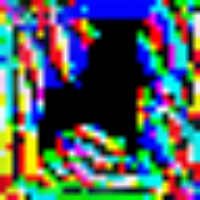

In [10]:
img = img.squeeze()

restore = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((200, 200))])
print('The minimum loss:', min_loss)
restore(img.cpu())

Let's invert plane

In [11]:
label_index = classes.index('plane')
img, min_loss = model_inversion(
    best_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.758352518081665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.001981496810913086
Loss: 0.0007460713386535645
Loss: 0.00045931339263916016
Loss: 0.00033855438232421875
Loss: 0.00026923418045043945
Loss: 0.00022143125534057617
Loss: 0.00018864870071411133
Loss: 0.00016546249389648438
Loss: 0.00014770030975341797


The minimum loss: 0.00013303756713867188


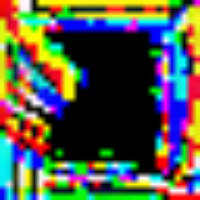

In [12]:
img = img.squeeze()

restore = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((200, 200))])
print('The minimum loss:', min_loss)
restore(img.cpu())

## MNIST

In [13]:
class NetBW(nn.Module):
  
  def __init__(self, num_classes):
    super(NetBW, self).__init__()
    self.resBlock1 = ResBlock(1, 8)
    self.dropout1 = nn.Dropout2d()
    self.resBlock2 = ResBlock(8, 16)
    self.dropout2 = nn.Dropout2d()
    self.resBlock3 = ResBlock(16, 32)
    self.dropout3 = nn.Dropout2d()
    self.resBlock4 = ResBlock(32, 64)
    self.dropout4 = nn.Dropout2d()
    self.classifier = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(64*28*28, 16*7*7),
      nn.ReLU(),
      nn.Linear(16*7*7, 10)
    )
    self.classifier.apply(self._init_weights)

  def forward(self, x):
    x = self.resBlock1(x)
    x = self.dropout1(x)
    x = self.resBlock2(x)
    x = self.dropout2(x)
    x = self.resBlock3(x)
    x = self.dropout3(x)
    x = self.resBlock4(x)
    x = self.dropout4(x)
    x = self.classifier(x)
    return x

  def _init_weights(self, m):
    if type(m) == nn.Linear:
      torch.nn.init.xavier_normal_(m.weight)


In [14]:
bw_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=bw_transform)
testset = torchvision.datasets.MNIST(
    './data', train=False, download=True, transform=bw_transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [15]:
MNIST_CNN = NetBW(10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MNIST_CNN.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2000)

In [16]:
epoch = 2
best_mnist_state = train(
    MNIST_CNN, epoch, valid_step, 
    optimizer, scheduler, criterion, trainloader, testloader)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Iteration 0: train loss: 4.241585, valid loss: 36.884598, accuracy: 0.095800, recall: 0.100000, precision: 0.009580
Epoch 1 Iteration 200: train loss: 0.833216, valid loss: 0.173227, accuracy: 0.948200, recall: 0.948508, precision: 0.950064
Epoch 1 Iteration 400: train loss: 0.486659, valid loss: 0.102245, accuracy: 0.967900, recall: 0.967875, precision: 0.967956
Epoch 1 Iteration 600: train loss: 0.362227, valid loss: 0.075644, accuracy: 0.975000, recall: 0.974585, precision: 0.975257
Epoch 1 Iteration 800: train loss: 0.292621, valid loss: 0.068045, accuracy: 0.980200, recall: 0.980280, precision: 0.980095
Epoch 1 Iteration 1000: train loss: 0.249309, valid loss: 0.077471, accuracy: 0.975800, recall: 0.975641, precision: 0.976363
Epoch 1 Iteration 1200: train loss: 0.221240, valid loss: 0.066535, accuracy: 0.980100, recall: 0.980254, precision: 0.979927
Epoch 1 Iteration 1400: train loss: 0.198957, valid loss: 0.084787, accuracy: 0.973500, recall: 0.973450, precision: 0.97382

In [17]:
print('Best result:')
print('Valid Loss:', best_mnist_state['valid_loss'])
print('Valid Accuracy:', best_mnist_state['accuracy'])
print('Precision:', best_mnist_state['precision'])
print('Recall:', best_mnist_state['recall'])

Best result:
Valid Loss: 0.034056311788650366
Valid Accuracy: 0.9883
Precision: 0.9882284567429872
Recall: 0.9882254572955521


Let's invert 7.

In [18]:
image_size = (1, 28, 28)
alpha = 5000
beta = 1000
gamma = 0.0001
lam = 0.1
if mode == 'DEBUG':
  alpha = 10
  beta = 10
  gamma = 0.01
  lam = 100

label_index = 7
img, min_loss = model_inversion(
    best_mnist_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.33020442724227905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.0024031996726989746
Loss: 0.001122891902923584
Loss: 0.0006666779518127441
Loss: 0.0004640817642211914
Loss: 0.00035512447357177734
Loss: 0.0002866387367248535
Loss: 0.00023955106735229492
Loss: 0.00020426511764526367
Loss: 0.00017780065536499023


The minimum loss: 0.00015664100646972656


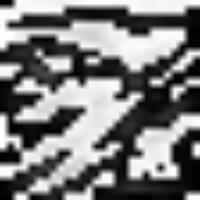

In [19]:
img = img.squeeze()

print('The minimum loss:', min_loss)
restore(img.cpu())

Let's invert the 0.

In [20]:
label_index = 0
img, min_loss = model_inversion(
    best_mnist_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.9889647960662842


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.0028635263442993164
Loss: 0.0014164447784423828
Loss: 0.0009527802467346191
Loss: 0.0007150769233703613
Loss: 0.0005768537521362305
Loss: 0.00048553943634033203
Loss: 0.00042241811752319336
Loss: 0.0003757476806640625
Loss: 0.00033974647521972656


The minimum loss: 0.0003107786178588867


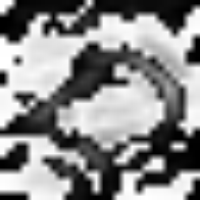

In [21]:
img = img.squeeze()

print('The minimum loss:', min_loss)
restore(img.cpu())

## Fashion-MNIST

In [22]:
trainset = torchvision.datasets.FashionMNIST(
    './data', train=True, download=True, transform=bw_transform)
testset = torchvision.datasets.FashionMNIST(
    './data', train=False, download=True, transform=bw_transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=2)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [23]:
Fashion_CNN = NetBW(10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Fashion_CNN.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2000)

In [24]:
epoch = 5
best_fashion_state = train(
    Fashion_CNN, epoch, valid_step, 
    optimizer, scheduler, criterion, trainloader, testloader)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Iteration 0: train loss: 5.272507, valid loss: 10.948916, accuracy: 0.102600, recall: 0.102600, precision: 0.121667
Epoch 1 Iteration 200: train loss: 0.917625, valid loss: 0.506157, accuracy: 0.813300, recall: 0.813300, precision: 0.820813
Epoch 1 Iteration 400: train loss: 0.669838, valid loss: 0.400711, accuracy: 0.851700, recall: 0.851700, precision: 0.856133
Epoch 1 Iteration 600: train loss: 0.575446, valid loss: 0.395572, accuracy: 0.856100, recall: 0.856100, precision: 0.859207
Epoch 1 Iteration 800: train loss: 0.521588, valid loss: 0.342547, accuracy: 0.874600, recall: 0.874600, precision: 0.878708
Epoch 1 Iteration 1000: train loss: 0.485383, valid loss: 0.327494, accuracy: 0.878200, recall: 0.878200, precision: 0.878487
Epoch 1 Iteration 1200: train loss: 0.456134, valid loss: 0.306885, accuracy: 0.888300, recall: 0.888300, precision: 0.888351
Epoch 1 Iteration 1400: train loss: 0.432097, valid loss: 0.288175, accuracy: 0.895000, recall: 0.895000, precision: 0.89444

In [25]:
print('Best result:')
print('Valid Loss:', best_fashion_state['valid_loss'])
print('Valid Accuracy:', best_fashion_state['accuracy'])
print('Precision:', best_fashion_state['precision'])
print('Recall:', best_fashion_state['recall'])

Best result:
Valid Loss: 0.24498985517329683
Valid Accuracy: 0.9087
Precision: 0.9085076098210019
Recall: 0.9086999999999998


Let's invert a bag image

In [26]:
image_size = (1, 28, 28)
alpha = 5000
beta = 1000
gamma = 0.0001
lam = 0.1
if mode == 'DEBUG':
  alpha = 10
  beta = 10
  gamma = 0.01
  lam = 100

label_index = trainset.classes.index('Bag')
img, min_loss = model_inversion(
    best_fashion_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.005523264408111572


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.00011789798736572266
Reach the min value; Loss is:  9.989738464355469e-05


The minimum loss: 9.989738464355469e-05


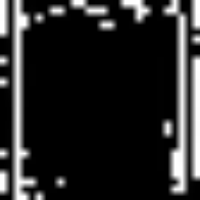

In [27]:
print('The minimum loss:', min_loss)
img = img.squeeze()
restore(img.cpu())

Let's invert a sneaker



In [28]:
label_index = trainset.classes.index('Sneaker')
img, min_loss = model_inversion(
    best_fashion_state['net'], label_index, alpha, beta, gamma, lam, image_size)

Loss: 0.9998809695243835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Loss: 0.9995118975639343
Loss: 0.00441133975982666
Loss: 0.0008298158645629883
Loss: 0.00046181678771972656
Loss: 0.00033020973205566406
Loss: 0.00025409460067749023
Loss: 0.00020450353622436523
Loss: 0.00017154216766357422
Loss: 0.00014781951904296875


The minimum loss: 0.00013017654418945312


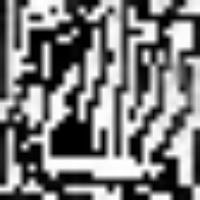

In [29]:
print('The minimum loss:', min_loss)
img = img.squeeze()
restore(img.cpu())